# **Pnevmoniya**

**Objective:** Ushbu ma'lumotlar to'plami zararlangan va zararlanmagan o'pkalarning tomografiyasini o'z ichiga oladi. Undan foydalangan holda so'glom va pnevmoniya kasalligi bilan shamollagan o'pkalarning rasmlarini ajratish.

- **Pneumonia** - https://en.wikipedia.org/wiki/Pneumonia
- **Deep Learning library - [fastai](https://docs.fast.ai/)**

In [1]:
import numpy as np
import pandas as pd

from fastai.vision.all import *
from ipywidgets import widgets

import requests
from io import BytesIO

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Dataset

'PosixPath' object is not iterable
Failed to verify: []


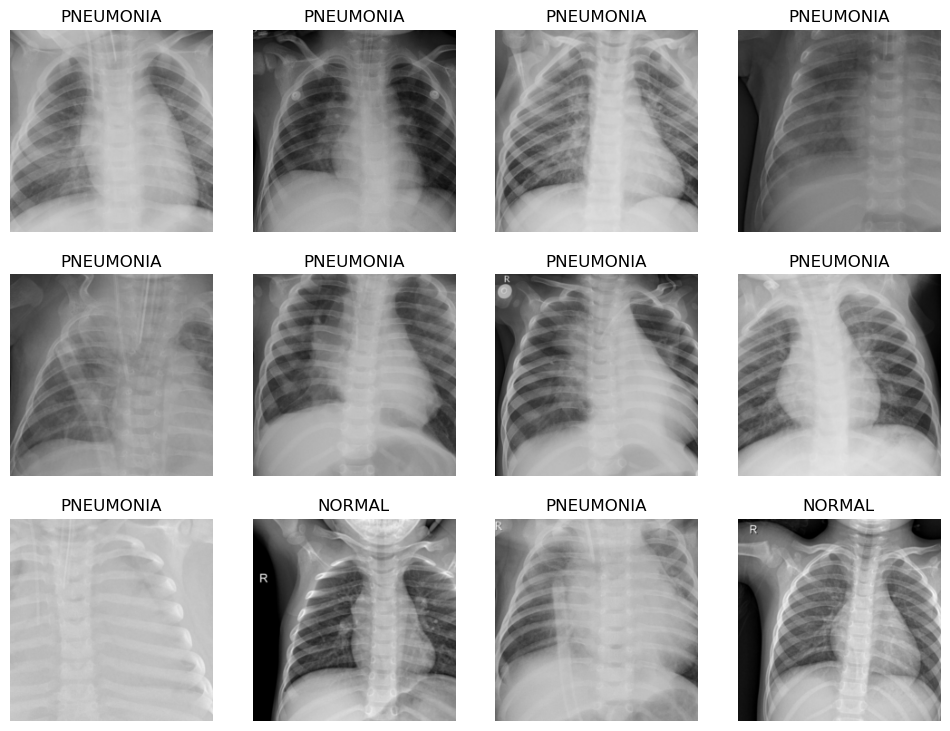

In [2]:
# train set
train_path = Path('/kaggle/input/pnevmoniya/train')
fls = get_image_files(train_path)

# check corrupted images (while downloading)
failed = verify_images(train_path)
print("Failed to verify:", failed)

# create data blocks for data loaders
transports = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.1, seed=42),
    get_y = parent_label,
    item_tfms = Resize(224)
)

# data loader
dls = transports.dataloaders(train_path)

# check dataset
dls.train.show_batch(max_n=12, nrows=3)

## Model

- **Deep Learnign Model:** [ResNet-152 architecture](https://arxiv.org/abs/1512.03385)

In [3]:
# Train
learn = vision_learner(dls, resnet152, metrics=accuracy)
learn.fine_tune(5)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 107MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.369962,0.182673,0.936660,02:24


epoch,train_loss,valid_loss,accuracy,time
0,0.151806,0.167417,0.969290,02:30
1,0.109519,0.095409,0.971209,02:32
2,0.056580,0.036660,0.990403,02:32
3,0.021614,0.058666,0.982726,02:32
4,0.010920,0.052064,0.990403,02:34


## Evaluation

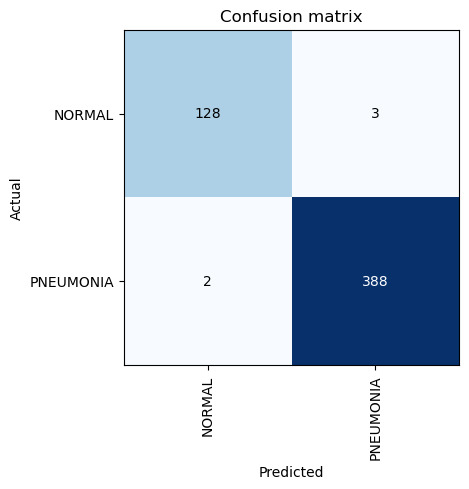

In [4]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [5]:
interp.print_classification_report()

              precision    recall  f1-score   support

      NORMAL       0.98      0.98      0.98       131
   PNEUMONIA       0.99      0.99      0.99       390

    accuracy                           0.99       521
   macro avg       0.99      0.99      0.99       521
weighted avg       0.99      0.99      0.99       521



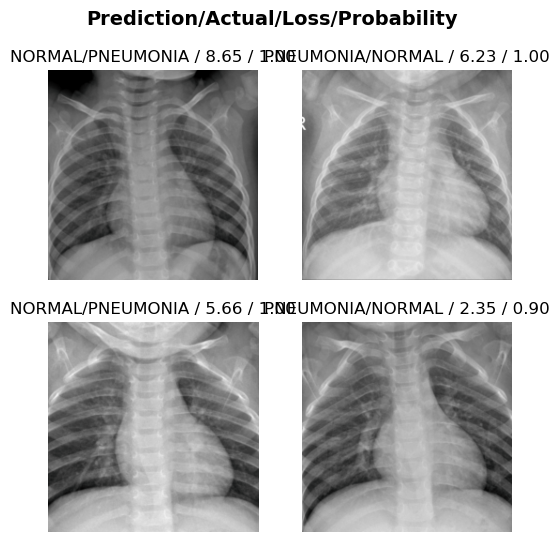

In [6]:
# the largest errors of the model
interp.plot_top_losses(4, nrows=2)

Sample chest X-ray of a pneumonia [image](https://upload.wikimedia.org/wikipedia/commons/8/81/Chest_radiograph_in_influensa_and_H_influenzae%2C_posteroanterior%2C_annotated.jpg) from Wikipedia.

Prediction: PNEUMONIA
Probability: 0.999016284942627


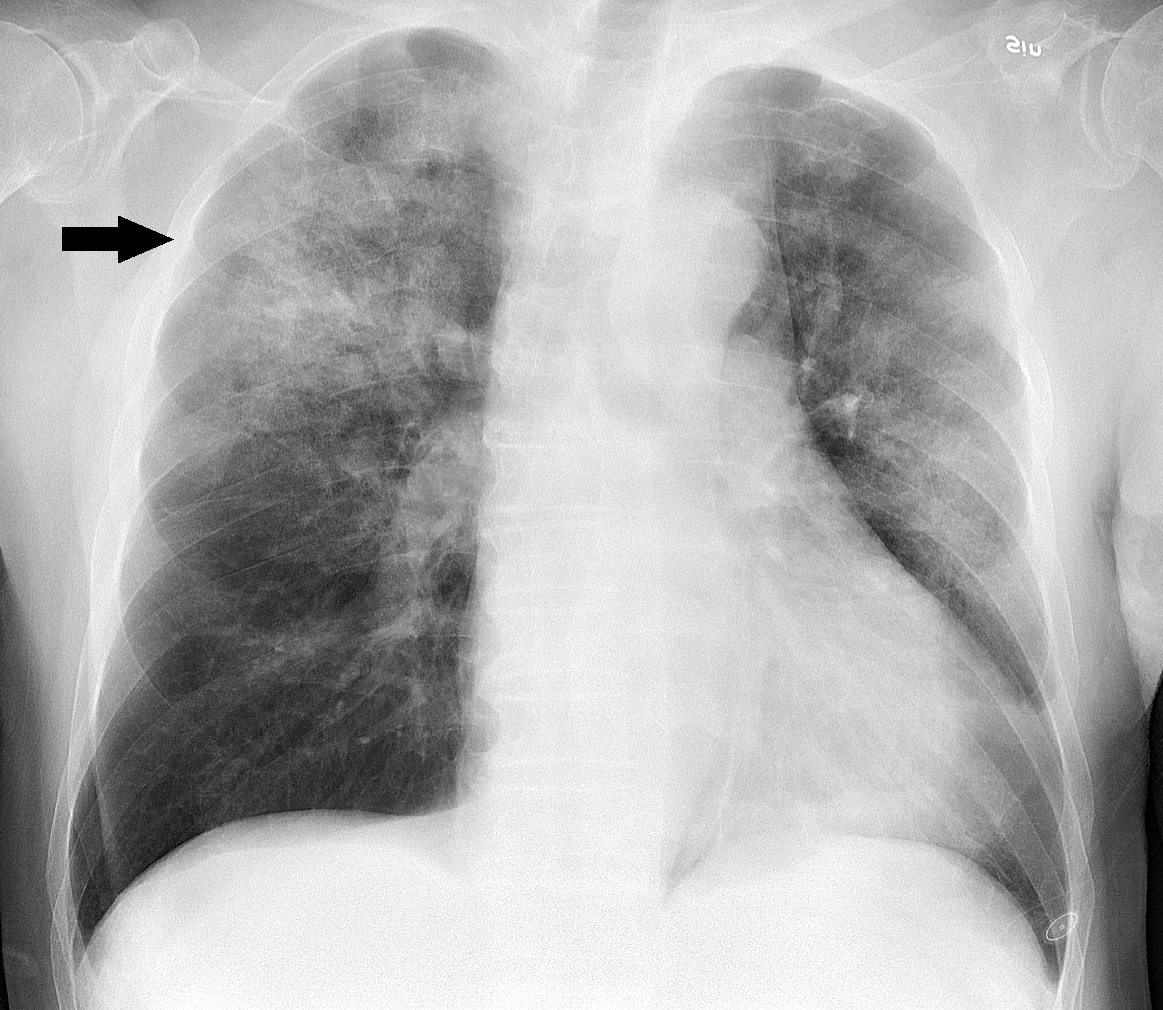

In [7]:
URL = "https://upload.wikimedia.org/wikipedia/commons/8/81/Chest_radiograph_in_influensa_and_H_influenzae%2C_posteroanterior%2C_annotated.jpg"
response = requests.get(URL)
img = PILImage.create(BytesIO(response.content))
pred, pred_id, probs = learn.predict(img)
print(f'Prediction: {pred}')
print(f'Probability: {probs[pred_id]}')
img

## Submission

In [8]:
sample_sub = pd.read_csv("/kaggle/input/pnevmoniya/sample_solution.csv")
sample_sub

,id,labels
0,test_img_10001.jpeg,0
1,test_img_10002.jpeg,0
2,test_img_10003.jpeg,0
3,test_img_10004.jpeg,0
4,test_img_10005.jpeg,0
...,...,...
619,test_img_10620.jpeg,0
620,test_img_10621.jpeg,0
621,test_img_10622.jpeg,0
622,test_img_10623.jpeg,0


In [ ]:
for row in range(len(sample_sub)):
    label = sample_sub.loc[row, 'id']
    img = PILImage.create(Path(f"/kaggle/input/pnevmoniya/test/{label}"))
    pred, pred_id, probs = learn.predict(img)
    sample_sub.loc[row, 'labels'] = np.array(probs[1])

In [10]:
sample_sub.to_csv('submission_resnet152_e5.csv', index=False)

In [11]:
pd.read_csv("/kaggle/working/submission_resnet152_e5.csv")

,id,labels
0,test_img_10001.jpeg,0.999729
1,test_img_10002.jpeg,0.001097
2,test_img_10003.jpeg,0.497283
3,test_img_10004.jpeg,0.999793
4,test_img_10005.jpeg,0.000030
...,...,...
619,test_img_10620.jpeg,0.998349
620,test_img_10621.jpeg,0.580661
621,test_img_10622.jpeg,0.999892
622,test_img_10623.jpeg,0.996767
